### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import psycopg2
import math
import datetime
import csv
import time
from postgis import Polygon,MultiPolygon
from postgis.psycopg import register
import trab_functions as aux
from importlib import reload
from ipywidgets import widgets
from IPython.display import HTML, display
import osmnx as ox

from matplotlib.colors import ListedColormap, LinearSegmentedColormap



### Definição de variáveis globais

### Estabelecer uma ligação com a base de dados

In [6]:
starttime=time.time()
DBNAME='tracks'
USER='nan'
conn = psycopg2.connect("dbname=%s user=%s" % (DBNAME,USER))
register(conn)
cursor_psql = conn.cursor()

if DEBUG : print("took %f seconds" % (time.time()-starttime))

took 0.035493 seconds


## Análise geral da tabela tracks<a name="análise"></a>

#### 2.1.1. Número de taxis

In [7]:
cursor_psql.execute('''SELECT COUNT(DISTINCT taxi) FROM tracks''')
results = cursor_psql.fetchall()
n_taxis= int(results[0][0])
print("Número de taxis: %d\n" % n_taxis)

Número de taxis: 1660



#### 2.1.2. Mostrar numero de trajetos que iniciaram a sua marcha a partir de que distritos

In [7]:
starttime=time.time()

cursor_psql.execute('''
                    SELECT distrito, count(*) 
                    FROM cont_aad_caop2018, tracks 
                    WHERE st_within(st_startpoint(proj_track),proj_boundary)
                    GROUP BY distrito ORDER BY 2 desc
                    ''')
results  = cursor_psql.fetchall()

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in results)
       )
))

if DEBUG : print("took %f seconds" % (time.time()-starttime))

LISBOA,47945
PORTO,33835
COIMBRA,14127
BRAGA,4129
AVEIRO,2062
SETÚBAL,134
SANTARÉM,19
FARO,5
VIANA DO CASTELO,4
LEIRIA,1


took 5.631249 seconds


#### 2.1.3. Mostrar numero de trajectos que terminaram a sua marcha em que distritos

In [6]:
starttime=time.time()

cursor_psql.execute('''
                    SELECT distrito, count(*) 
                    FROM cont_aad_caop2018, tracks 
                    WHERE st_within(st_endpoint(proj_track),proj_boundary)
                    GROUP BY distrito 
                    ORDER BY 2 desc
                    '''
)
fields = tuple([field[0] for field in cursor_psql.description])
results  = cursor_psql.fetchall()
results.insert(0,fields)

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in results)
       )
))

if DEBUG : print("took %f seconds" % (time.time()-starttime))

distrito,count
LISBOA,47951
PORTO,33830
COIMBRA,14128
BRAGA,4132
AVEIRO,2065
SETÚBAL,125
SANTARÉM,19
FARO,5
VIANA DO CASTELO,3


took 3.388948 seconds


### Carregar o csv com os offsets, epidemia e calcular os histogramas

In [21]:
epidemic_array=["epidemic_P10_D50","epidemic_P10_D10", "epidemic_P10_D50_with_immunity"]
epidemic_menu = widgets.Dropdown(value=epidemic_array[0],options=epidemic_array,description='Epidemia')
widgets.VBox([epidemic_menu])

In [24]:
starttime=time.time()

#OFFSETS_CSV = epidemic_menu.value + ".csv"
OFFSETS_CSV='offsets3.csv'
EPIDEMIC_CSV='epidemic.csv'

OFFSETS   = aux.read_offsets(OFFSETS_CSV)
infected  = aux.read_csv(EPIDEMIC_CSV)
histogram = aux.get_histograms(["PORTO","LISBOA","*"], infected, OFFSETS, cursor_psql)

if DEBUG : print("took %f seconds" % (time.time()-starttime))

took 33.164469 seconds


### Animação no mapa de Portugal <a name="animação_país"></a>

Traceback (most recent call last):
  File "/usr/local/lib64/python3.7/site-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib64/python3.7/site-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


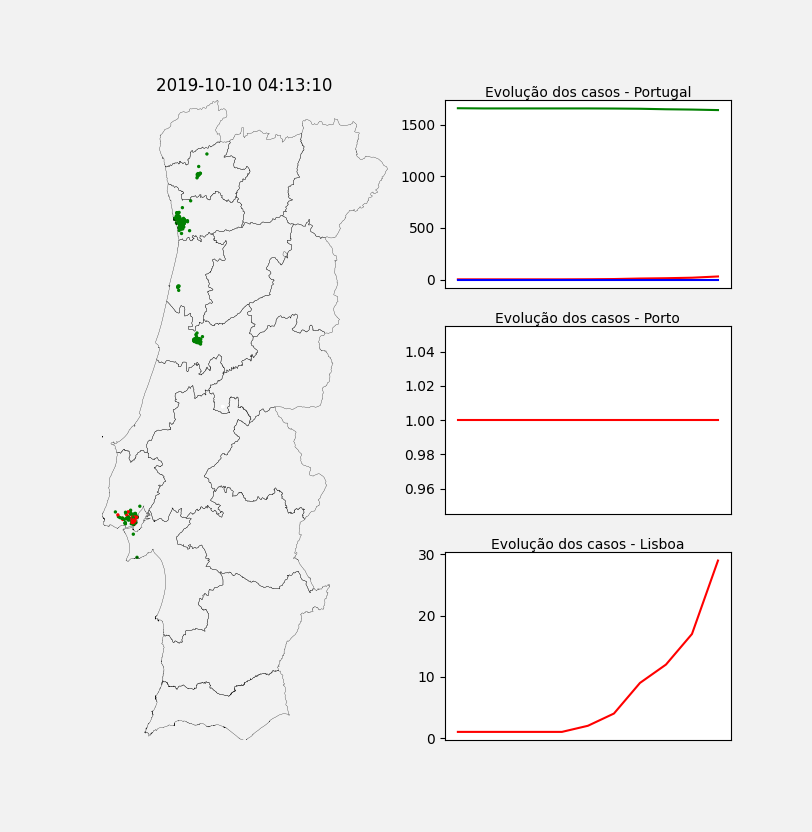

In [26]:
starttime=time.time()

%matplotlib notebook

plt.rcParams['figure.facecolor'] = '#F2F2F2'

cmap = ListedColormap(["green", "red", "blue","white"])
query = '''SELECT  min(st_xmin(proj_boundary)) as xmin, max(st_xmax(proj_boundary)) as xmax, 
                   min(st_ymin(proj_boundary)) as ymin, max(st_ymax(proj_boundary)) as ymax 
           FROM cont_aad_caop2018 '''

cursor_psql.execute(query)
results = cursor_psql.fetchall()
xs_min, xs_max, ys_min, ys_max = results[0][0], results[0][1], results[0][2], results[0][3]

width_in_inches  = (xs_max-xs_min)/0.0254*1.1
height_in_inches = (ys_max-ys_min)/0.0254*1.1
scale, ts_i = 1/3000000, 1570665600

query = ''' SELECT distrito,st_union(proj_boundary) FROM cont_aad_caop2018  GROUP BY distrito '''
cursor_psql.execute(query)
results = cursor_psql.fetchall()

#mapear posicoes 0 0 com o valor 3
for x in range(0,len(OFFSETS)):
    for y in range(0,len(OFFSETS[x])):
        if(OFFSETS[x][y][0]==0 and OFFSETS[x][y][1]==0):
            infected[x][y]=float(3)

cmap = ListedColormap(["green", "red", "blue","white" ])

color_data = np.array(infected)

fig= plt.figure(figsize=(2*width_in_inches*scale , height_in_inches*scale)) 
#fig= plt.figure() 

gs = gridspec.GridSpec(3, 2)
bool_rewind=False

pt_map1 = plt.subplot(gs[0:3, 0])
pt_map1.axis('off')
pt_map1.set(xlim=(xs_min, xs_max), ylim=(ys_min, ys_max))
fig.add_subplot(pt_map1)

labels, ax = ["Portugal", "Porto", "Lisboa"], []
for i in range(0,len(labels)):
    ax.append(plt.subplot(gs[i,1]))
    ax[i].set_title("Evolução dos casos - %s" % labels[i],x=0.5, y=0.8)
    fig.add_subplot(ax[i])
    ax[i].axes.xaxis.set_visible(False) 

scat = pt_map1.scatter([x[0] for x in OFFSETS[0]], [y[1] for y in OFFSETS[0]],
                       c=[1]*1660, s=2, cmap=cmap, vmin=0, vmax=3)

aux.show_map(results,pt_map1)

k=0
index_i=1
speed=1
def animate(i):
    global index_i
    k=int(slider.value)
    index_i=int(k/120)

    pt_map1.set_title(datetime.datetime.utcfromtimestamp(ts_i+k*10))
    
    if(i%120==0):
        for j in range(0,len(labels)):
            ax[j].clear()
            ax[j].set_title("Evolução dos casos - %s" % labels[j], x=0.5, y=.97,fontsize= 10)
       
        ax[0].plot(range(1,index_i),histogram["*"]["S"][1:index_i],color='green')
        ax[0].plot(range(1,index_i),histogram["*"]["I"][1:index_i],color='red')
        ax[0].plot(range(1,index_i),histogram["*"]["R"][1:index_i],color='blue')
        ax[1].plot(range(1,index_i),histogram["PORTO"]["I"][1:index_i],color='red')       
        ax[2].plot(range(1,index_i),histogram["LISBOA"]["I"][1:index_i],color='red')
        index_i+=1

    scat.set_array(color_data[k])
    scat.set_offsets(OFFSETS[k])
    k+=1
    slider.value=k

anim = FuncAnimation(fig, animate, interval=1, frames=len(OFFSETS)-1, repeat=True)

plt.show()
slider = widgets.IntSlider(value=0, min=0, max=len(OFFSETS), step=1, description='', disabled=False, 
    continuous_update=True, orientation='horizontal',__output_result=False)

start_button = widgets.Button(description='pause',disabled=False,button_style='success',icon='pause')

def event(button):
    if (button.description in ['start', 'resume']):
        anim.event_source.start()
        start_button.description='pause'
        start_button.icon='pause'
    else:
        anim.event_source.stop()
        start_button.description='resume' 
        start_button.icon='play'
   
start_button.on_click(event)
widgets.HBox([start_button, slider])


<IPython.core.display.Javascript object>


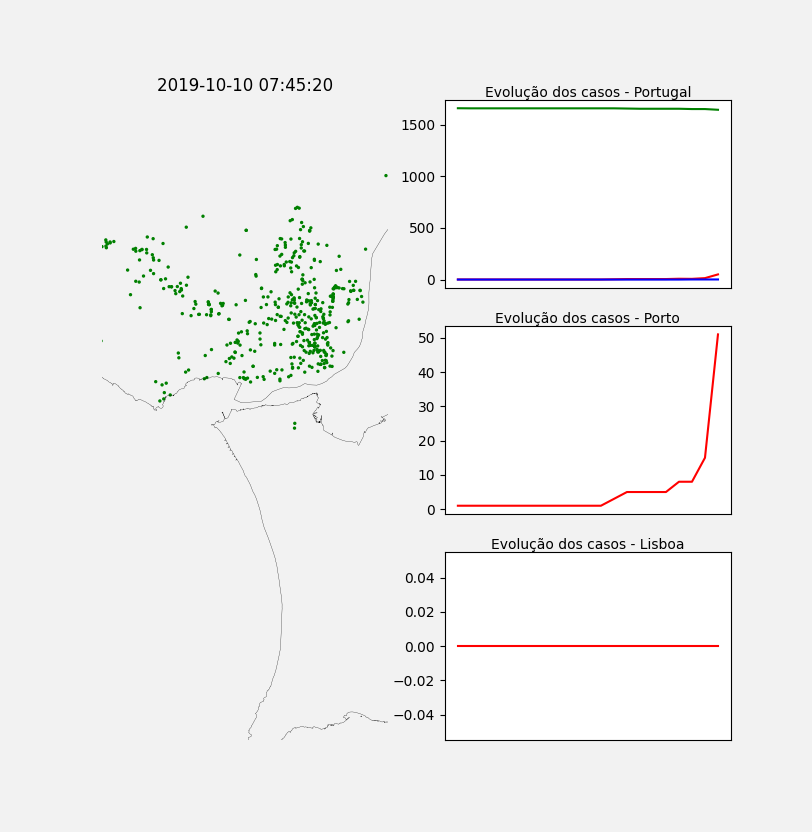

In [14]:
#mapear posicoes 0 0 com o valor 3
for x in range(0,len(OFFSETS)):
    for y in range(0,len(OFFSETS[x])):
        if(OFFSETS[x][y][0]==0 and OFFSETS[x][y][1]==0):
            infected[x][y]=float(3)

cmap = ListedColormap(["green", "red", "blue","white" ])

color_data = np.array(infected)

fig= plt.figure(figsize=(2*width_in_inches*scale , height_in_inches*scale)) 
#fig= plt.figure() 

gs = gridspec.GridSpec(3, 2)
bool_rewind=False

pt_map1 = plt.subplot(gs[0:3, 0])
pt_map1.axis('off')
pt_map1.set(xlim=(xs_min, xs_max), ylim=(ys_min, ys_max))
fig.add_subplot(pt_map1)

labels, ax = ["Portugal", "Porto", "Lisboa"], []
for i in range(0,len(labels)):
    ax.append(plt.subplot(gs[i,1]))
    ax[i].set_title("Evolução dos casos - %s" % labels[i],x=0.5, y=0.8)
    fig.add_subplot(ax[i])
    ax[i].axes.xaxis.set_visible(False) 

scat = pt_map1.scatter([x[0] for x in OFFSETS[0]], [y[1] for y in OFFSETS[0]],
                       c=[1]*1660, s=2, cmap=cmap, vmin=0, vmax=3)

aux.show_map(results,pt_map1)

k=0
index_i=1
speed=1
def animate(i):
    global index_i
    k=int(slider.value)
    index_i=int(k/120)

    pt_map1.set_title(datetime.datetime.utcfromtimestamp(ts_i+k*10))
    
    if(i%120==0):
        for j in range(0,len(labels)):
            ax[j].clear()
            ax[j].set_title("Evolução dos casos - %s" % labels[j], x=0.5, y=.97,fontsize= 10)
       
        ax[0].plot(range(1,index_i),histogram["*"]["S"][1:index_i],color='green')
        ax[0].plot(range(1,index_i),histogram["*"]["I"][1:index_i],color='red')
        ax[0].plot(range(1,index_i),histogram["*"]["R"][1:index_i],color='blue')
        ax[1].plot(range(1,index_i),histogram["PORTO"]["I"][1:index_i],color='red')       
        ax[2].plot(range(1,index_i),histogram["LISBOA"]["I"][1:index_i],color='red')
        index_i+=1

    scat.set_array(color_data[k])
    scat.set_offsets(OFFSETS[k])
    k+=1
    slider.value=k

anim = FuncAnimation(fig, animate, interval=1, frames=len(OFFSETS)-1, repeat=True)

plt.show()
slider = widgets.IntSlider(value=0, min=0, max=len(OFFSETS), step=1, description='', disabled=False, 
    continuous_update=True, orientation='horizontal',__output_result=False)

start_button = widgets.Button(description='pause',disabled=False,button_style='success',icon='pause')

def event(button):
    if (button.description in ['start', 'resume']):
        anim.event_source.start()
        start_button.description='pause'
        start_button.icon='pause'
    else:
        anim.event_source.stop()
        start_button.description='resume' 
        start_button.icon='play'
   
start_button.on_click(event)
widgets.HBox([start_button, slider])


## Animação da epidemia em diferentes distritos <a name="animação_distrítos"></a>

### Seleccionar um Distrito, intervalo de tempo e escala

In [15]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

query = '''
        SELECT DISTINCT distrito 
        FROM cont_aad_caop2018
        ORDER BY 1 asc
        '''
cursor_psql.execute(query)
results  = cursor_psql.fetchall()
distritos = [d[0] for d in results]

distritos_menu = widgets.Dropdown(value=distritos[0],options=distritos,description='Distrito')
horas_slider = widgets.IntRangeSlider(value=(10, 14), min=0, max=23, step=1, description='Intervalo (h)')

widgets.VBox([distritos_menu,horas_slider])

### Mostrar a animação

<IPython.core.display.Javascript object>


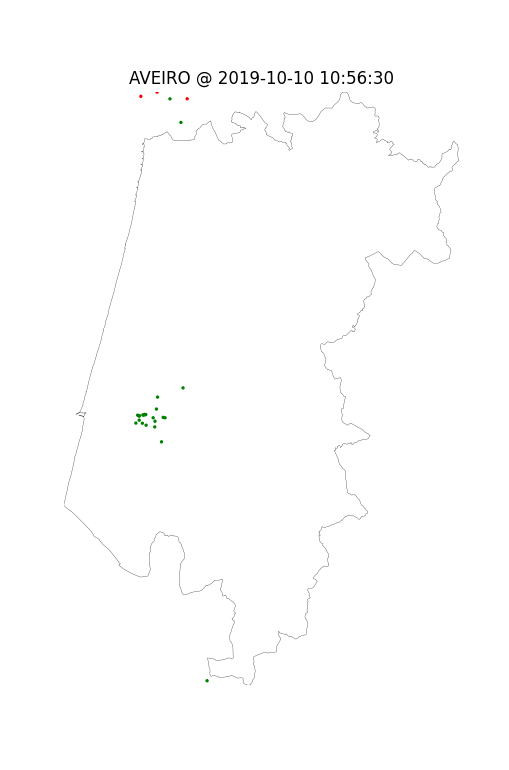

took 1 seconds


In [16]:
%matplotlib notebook
plt.rcParams['figure.facecolor'] = 'white'

""" Carregar os valores de input """
distrito=distritos_menu.value
(hora_inicial, hora_final) = horas_slider.value
scale=1/500000

starttime=time.time()

query='''
        SELECT 
            distrito, st_union(proj_boundary) as pol, 
            min(st_xmin(proj_boundary)) as xmin, 
            max(st_xmax(proj_boundary)) as xmax, 
            min(st_ymin(proj_boundary)) as ymin, 
            max(st_ymax(proj_boundary)) as ymax 
        FROM cont_aad_caop2018 WHERE distrito='%s'
        GROUP BY distrito
 ''' % distrito


cursor_psql.execute(query)
results  = cursor_psql.fetchall()

xs_min, xs_max, ys_min, ys_max = results[0][2], results[0][3], results[0][4], results[0][5]
width_in_inches  = (xs_max-xs_min)/0.0254*1.1
height_in_inches = (ys_max-ys_min)/0.0254*1.1

ts_hora_i = ts_i+3600*hora_inicial
ts_hora_f = ts_i+3600*hora_final

fig= plt.figure(figsize=(width_in_inches*scale , height_in_inches*scale)) 

gs = gridspec.GridSpec(1, 1)

mapa_distrito = plt.subplot(gs[0, 0])
mapa_distrito.axis('off')
mapa_distrito.set(xlim=(xs_min, xs_max), ylim=(ys_min, ys_max))

fig.add_subplot(mapa_distrito) 
aux.show_map(results,mapa_distrito)

scat = mapa_distrito.scatter([x[0] for x in OFFSETS[0]], [y[1] for y in OFFSETS[0]],
                       c=[1]*1660, s=2, cmap=cmap, vmin=0, vmax=3)
def animate(i):

    mapa_distrito.set_title(distrito + " @ " + str(datetime.datetime.utcfromtimestamp(ts_hora_i+i*10)))
    if(i>=(hora_final-hora_inicial)*360):
        anim.event_source.stop()    

    scat.set_array(color_data[i+hora_inicial*360])
    scat.set_offsets(OFFSETS[i+hora_inicial*360])
    anim.event_source.interval=10-speed_button.value*10+1
    
anim = FuncAnimation(fig, animate, interval=1, frames=len(OFFSETS)-1, repeat = False)

start_button = widgets.Button(description='Start',disabled=False,button_style='success',icon='play')
pause_button = widgets.Button(description='Pause',disabled=False,button_style='info',icon='pause')
zoom_in_button = widgets.Button(description='Zoom_in',disabled=False,button_style='info',icon='zoom')
zoom_out_button = widgets.Button(description='Zoom_out',disabled=False,button_style='info',icon='zoom')
speed_button= widgets.FloatSlider(value=.5, min=0,  max=1, step=0.1, description='Speed:', disabled=False,
    continuous_update=False,    orientation='horizontal',  readout=True,   readout_format='d')
#slider = widgets.IntSlider(value=0, min=0, max=len(OFFSETS), step=1, description='', disabled=False, 
#    continuous_update=True, orientation='horizontal')

def event(button):
    anim.event_source.start() if button.description=='Start' else anim.event_source.stop()

def zoom_event(button):
    global scale
    if button.description=="Zoom_in": 
        scale+=1/50000000
    else:                               
        scale-=1/50000000
    fig.set_size_inches(width_in_inches*scale, height_in_inches*scale, forward=True)


if DEBUG: print("took %d seconds" % (time.time()-starttime))   
    
start_button.on_click(event)
pause_button.on_click(event)
zoom_in_button.on_click(zoom_event)
zoom_out_button.on_click(zoom_event)
widgets.HBox([start_button, pause_button,zoom_in_button, zoom_out_button, speed_button])

<IPython.core.display.Javascript object>


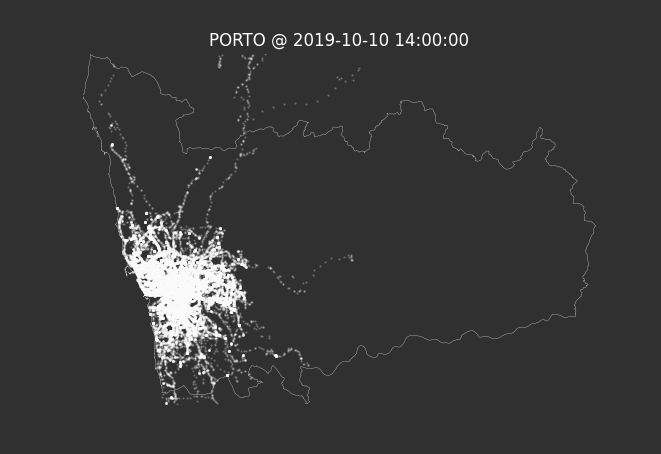

took 1 seconds


In [18]:
%matplotlib notebook

from matplotlib.colors import ListedColormap, LinearSegmentedColormap 
cmap = ListedColormap(["lawngreen", "blue", "red","white"])
plt.rcParams['figure.facecolor'] = '#303030'


""" Carregar os valores de input """
distrito=distritos_menu.value
(hora_inicial, hora_final) = horas_slider.value
scale=1/500000

starttime=time.time()


#Obter o poligono do distrito
query='''
        select 
            distrito, st_union(proj_boundary) as pol, 
            min(st_xmin(proj_boundary)) as xmin, 
            max(st_xmax(proj_boundary)) as xmax, 
            min(st_ymin(proj_boundary)) as ymin, 
            max(st_ymax(proj_boundary)) as ymax 
        from cont_aad_caop2018 where distrito='%s'
        group by distrito
 ''' % distrito


cursor_psql.execute(query)
results  = cursor_psql.fetchall()

xs_min, xs_max, ys_min, ys_max = results[0][2], results[0][3], results[0][4], results[0][5]
width_in_inches  = (xs_max-xs_min)/0.0254*1.1
height_in_inches = (ys_max-ys_min)/0.0254*1.1
ts_i= 1570665600

ts_hora_i = ts_i+3600*hora_inicial
ts_hora_f = ts_i+3600*hora_final


fig= plt.figure(figsize=(width_in_inches*scale , height_in_inches*scale)) 

gs = gridspec.GridSpec(1, 1)

mapa_distrito = plt.subplot(gs[0, 0])
mapa_distrito.axis('off')
mapa_distrito.set(xlim=(xs_min, xs_max), ylim=(ys_min, ys_max))

fig.add_subplot(mapa_distrito) 

aux.show_map(results,mapa_distrito, "white")


xx,yy=[],[]
for i in OFFSETS[0]:
    xx.append(i[0])
    yy.append(i[1])

colors_=[]
offsets_=[]
pos_=[]
scat = mapa_distrito.scatter(xx,yy,color="white",s=.5,alpha=.2)

x_=[]
y_=[]

def animate(i):
    str_ = distrito + " @ " + str(datetime.datetime.utcfromtimestamp(ts_hora_i+i*10))
    mapa_distrito.set_title(str_, color='white')
    anim.event_source.interval=speed_button.value

    if(i>=(hora_final-hora_inicial)*360):  
        anim.event_source.stop()
    
    if (i%6==0): #de 1 em 1 mins
        pos_=[]
        for j in range(0,len(OFFSETS[i+hora_inicial*360])):
            pos = OFFSETS[i+hora_inicial*360][j]
            if (pos[0]>=xs_min and xs_max>=pos[0] and pos[1]>=ys_min and ys_max>=pos[1]):
                offsets_.append(pos)
        
        scat.set_offsets(offsets_)

        
anim = FuncAnimation(fig, animate, interval=1, frames=len(OFFSETS)-1, repeat = False)

start_button = widgets.Button(description='Start',disabled=False,button_style='success',icon='play')
pause_button = widgets.Button(description='Pause',disabled=False,button_style='info',icon='pause')
zoom_in_button = widgets.Button(description='Zoom_in',disabled=False,button_style='info',icon='zoom')
zoom_out_button = widgets.Button(description='Zoom_out',disabled=False,button_style='info',icon='zoom')
speed_button= widgets.IntSlider(value=10, min=1,  max=20, step=1, description='Speed:', disabled=False,
    continuous_update=False,    orientation='horizontal',  readout=True,   readout_format='d'
)

def event(button):
    anim.event_source.start() if button.description=='Start' else anim.event_source.stop()

def zoom_event(button):
    global scale
    if button.description=="Zoom_in": 
        scale+=1/50000000
    else:                               
        scale-=1/50000000
    fig.set_size_inches(width_in_inches*scale, height_in_inches*scale, forward=True)


if DEBUG: print("took %d seconds" % (time.time()-starttime))   
    

start_button.on_click(event)
pause_button.on_click(event)
zoom_in_button.on_click(zoom_event)
zoom_out_button.on_click(zoom_event)
widgets.HBox([start_button, pause_button,zoom_in_button, zoom_out_button, speed_button])

## Animação em concelhos específicos <a name="animação_concelhos"></a>

### Escolher um concelho específico

In [19]:
distrito=distritos_menu.value
(hora_inicial, hora_final) = horas_slider.value

#query para obter concelhos
query = '''
        SELECT DISTINCT concelho, distrito 
        FROM cont_aad_caop2018
        WHERE distrito='%s'
        ORDER BY 1 asc
        ''' % (distrito)
cursor_psql.execute(query)
results  = cursor_psql.fetchall()
concelhos = [c[0] for c in results]

concelhos_menu = widgets.Dropdown(value=concelhos[0],options=concelhos,description='Concelho')
widgets.VBox([concelhos_menu])

### Gerar o mapa do concelho usando a biblioteca osmnx

In [20]:
''' Criar o mapa do concelho'''
import matplotlib.pyplot as plt
import osmnx as ox 
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
ox.config(log_console=True, use_cache=True)
ox.__version__
ts_i= 1570665600

starttime = time.time()

concelho=concelhos_menu.value

#query para obter o centroide e distancia maxima ao centroide num concelho
query = '''
         SELECT  st_astext(st_transform(centroid,4236)) as centroid, 
                 st_maxdistance(centroid,pol) as dist 
         FROM
         (
                SELECT pol, st_centroid(pol) as centroid
                    FROM (
                        SELECT concelho, st_union(proj_boundary) as pol 
                        FROM cont_aad_caop2018
                        WHERE concelho='%s'
                        GROUP BY concelho
                    ) as foo
        ) as foo2
        ''' % (concelho)
cursor_psql.execute(query)
results = cursor_psql.fetchall()
point = results[0][0]

lon,lat = point[len('POINT('):-1].split(" ") #remove a substring POINT( no inicio da string e ) do fim da string
lat = float(lat)
lon = float(lon)
distance = float(results[0][1])

starttime=time.time()

G = ox.graph_from_point((lat,lon),distance=distance)

if DEBUG : print(time.time()-starttime)

33.035170555114746


<IPython.core.display.Javascript object>


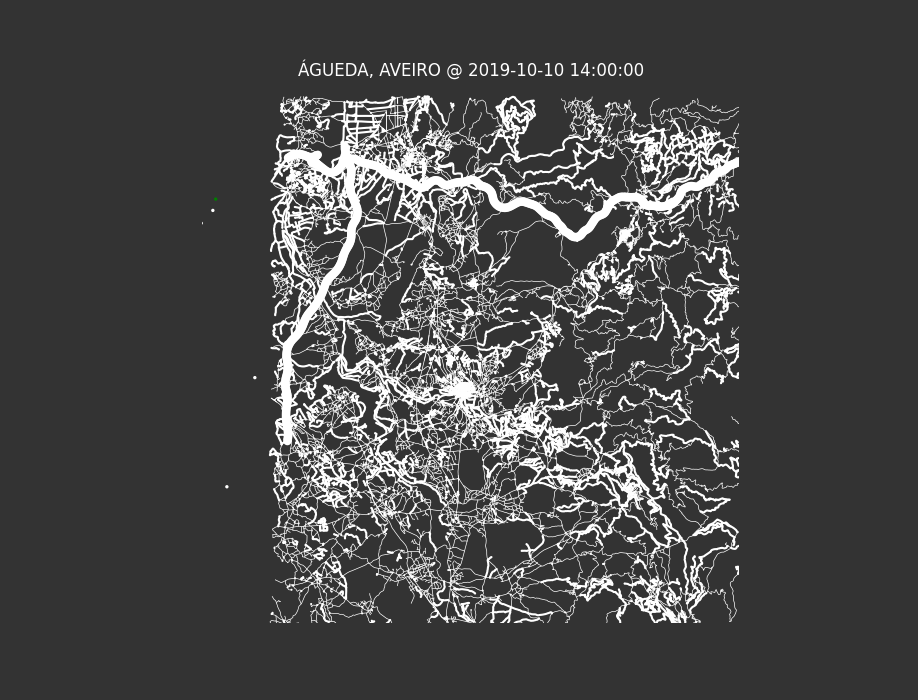

took 6 seconds


In [28]:
i=0
index1= 360*hora_inicial
index2=360*hora_final
starttime=time.time()
count_e=0
count_n=0

#converter as coordenadas projectadas no sistema 3763 (como estão na nossa bd e no offsets)
#para o 4326 (mais comum e usado)
import pyproj
proj = pyproj.Transformer.from_crs(3763, 4326, always_xy=True) 

offsets_4326 = []
for r in range(index1,index1+1800):
    tmp=[]
    for c in range(0,len(OFFSETS[r])):
        if (OFFSETS[r][c][0]!=0):
            lat,lon = proj.transform(OFFSETS[r][c][0], OFFSETS[r][c][1])
            tmp.append([lat,lon])
        else:
            tmp.append(OFFSETS[r][c])
    offsets_4326.append(tmp)

''' mostrar a animação no concelho'''




<IPython.core.display.Javascript object>


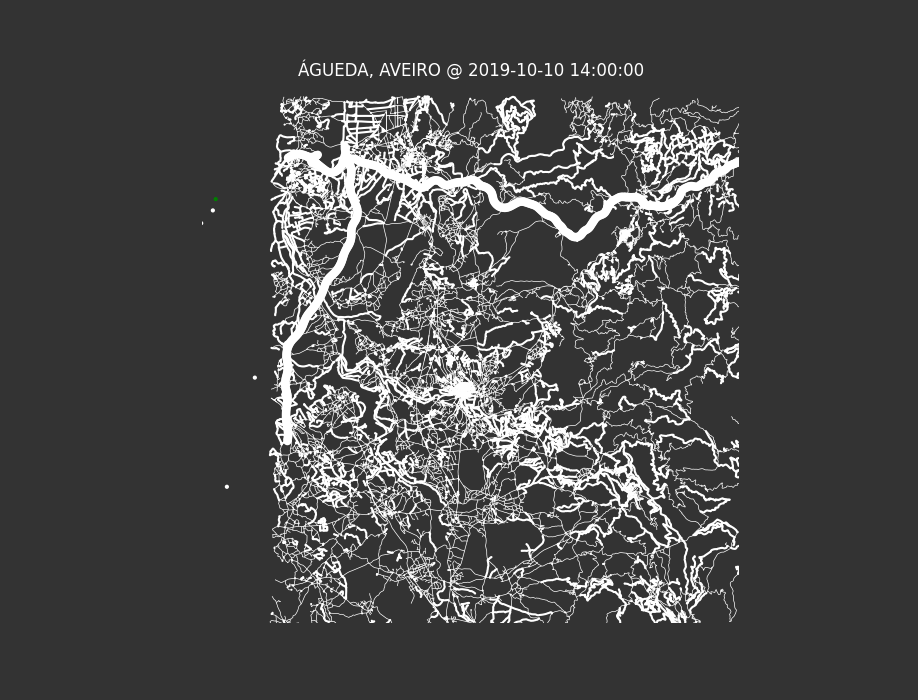

took 5 seconds


In [51]:
%matplotlib notebook
cmap = ListedColormap(["green", "blue", "red","white"])

starttime=time.time()

fig, ax = ox.plot_figure_ground(G, default_width=.5, network_type='drive', fig_length=7, 
                                dist=distance, show=False, close=False)

ts_hora_i, ts_hora_f = ts_i+3600*hora_inicial, ts_i+3600*hora_final
num_taxis=len(OFFSETS[0])

scat = ax.scatter([x[0] for x in OFFSETS[0]], [y[1] for y in OFFSETS[0]],
                       c=[1]*1660, s=4, cmap=cmap, vmin=0, vmax=3)

def animate(i):
    k=int(slider.value)
    ax.set_title(concelho + ", " + distrito + " @ " + str(datetime.datetime.utcfromtimestamp(ts_hora_i+k*10)),
                 color="white")

    if(k>=(hora_final-hora_inicial)*360):
        anim.event_source.stop()
    scat.set_offsets(offsets_4326[k])
    scat.set_array(color_data[k])
    k+=1
    slider.value=k
    

anim = FuncAnimation(fig, animate, interval=1, frames=len(offsets_4326)-1, repeat=True)

start_button = widgets.Button(description='Start',disabled=False,button_style='success',icon='play')
pause_button = widgets.Button(description='Pause',disabled=False,button_style='info',icon='pause')
zoom_in_button = widgets.Button(description='Zoom_in',disabled=False,button_style='info',icon='zoom')
zoom_out_button = widgets.Button(description='Zoom_out',disabled=False,button_style='info',icon='zoom')
speed_button= widgets.IntSlider(value=10, min=1,  max=20, step=1, description='Speed:', disabled=False,
    continuous_update=False,    orientation='horizontal',  readout=True,   readout_format='d')
slider = widgets.IntSlider(value=0, min=0, max=(hora_final-hora_inicial)*360, step=1, description='', disabled=False, 
    continuous_update=True, orientation='horizontal',__output_result=False)

def event(button):
    anim.event_source.start() if button.description=='Start' else anim.event_source.stop()

def zoom_event(button):
    global scale
    if button.description=="Zoom_in": 
        scale+=1/50000000
    else:                               
        scale-=1/50000000
    fig.set_size_inches(width_in_inches*scale, height_in_inches*scale, forward=True)


if DEBUG: print("took %d seconds" % (time.time()-starttime))   
    

start_button.on_click(event)
pause_button.on_click(event)
zoom_in_button.on_click(zoom_event)
zoom_out_button.on_click(zoom_event)
widgets.HBox([start_button, pause_button,zoom_in_button, zoom_out_button, speed_button, slider])


In [37]:
distance

14871.11107037925

In [50]:
ax